In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

# --- 1. Load and Prepare Data ---
df = pd.read_csv("arecanut.csv")
df['Price Date'] = pd.to_datetime(df['Price Date'])
df.sort_values('Price Date', inplace=True)

price_data = df[['Max Price (Rs./Quintal)']].values

# --- 2. Scale the Data ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# --- 3. Create Sequences ---
SEQUENCE_LENGTH = 30
train_size = int(len(scaled_data) * 0.8)

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQUENCE_LENGTH:]

X_train, y_train, X_test, y_test = [], [], [], []

# Training sequences
for i in range(SEQUENCE_LENGTH, len(train_data)):
    X_train.append(train_data[i - SEQUENCE_LENGTH:i, 0])
    y_train.append(train_data[i, 0])

# Testing sequences
for i in range(SEQUENCE_LENGTH, len(test_data)):
    X_test.append(test_data[i - SEQUENCE_LENGTH:i, 0])
    y_test.append(test_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# --- 4. Build and Train the LSTM Model ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# --- 5. Save Model, Scaler, and Test Data ---
model.save('model_adike.h5')
joblib.dump(scaler, 'scaler_adike.gz')
print("Model saved as 'model_adike.h5'")
print("Scaler saved as 'scaler_adike.gz'")


Epoch 1/100
81/81 [==============================] - 3s 14ms/step - loss: 0.0104
Epoch 2/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 3/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0045
Epoch 4/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0045
Epoch 5/100
81/81 [==============================] - 1s 13ms/step - loss: 0.0045
Epoch 6/100
81/81 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 7/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 8/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0045
Epoch 9/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 10/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 11/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 12/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 13/100
81/81 [=====

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 0s 3ms/step


/var/folders/ls/k1p_ptn500g_fx4qdb8780cc0000gp/T/ipykernel_56826/60049535.py:33: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  plt.tight_layout()
/Users/adityarao/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


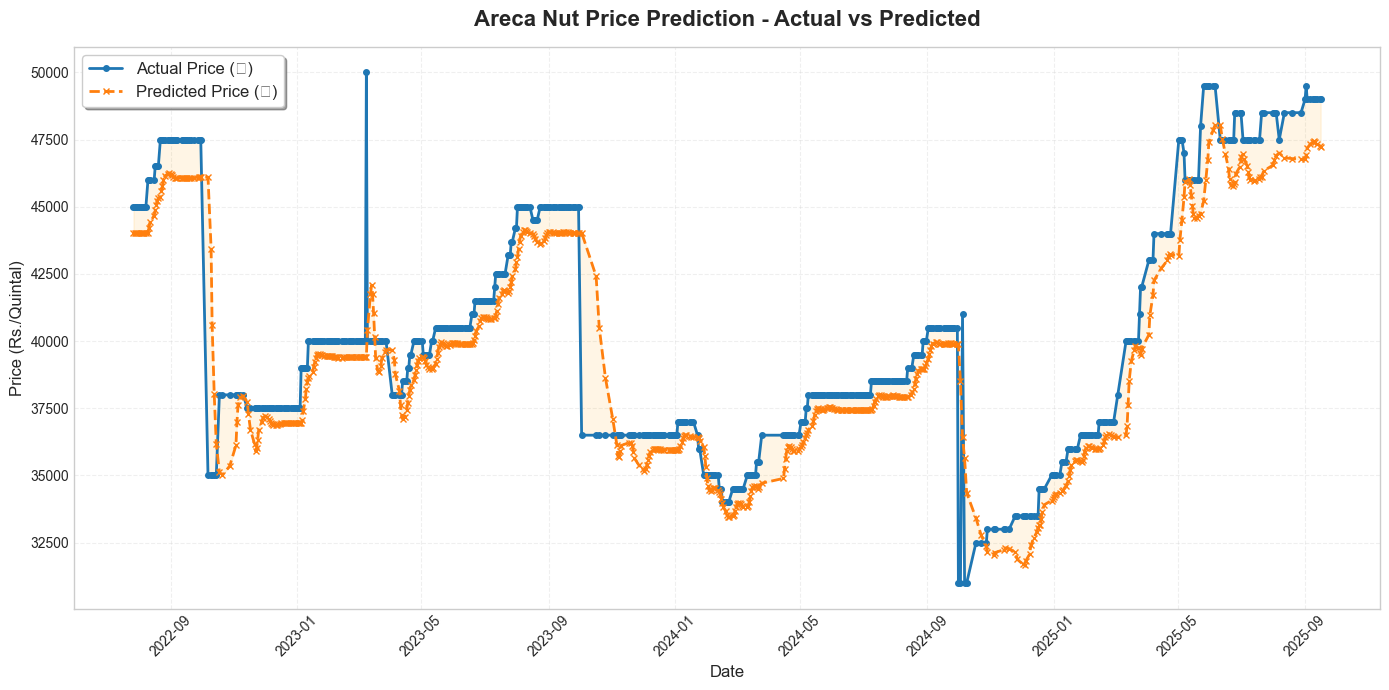


Mean Absolute Error (MAE): 1026.11
R² Score: 0.8843


In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, r2_score
df['Price Date'] = pd.to_datetime(df['Price Date'])

# --- 2. Predict ---
y_pred = model.predict(X_test)

# --- 3. Inverse Transform ---
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- 4. Get Matching Dates ---
test_dates = df['Price Date'].iloc[-len(y_test_inv):]

# --- 5. Plot Actual vs Predicted ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14,7))

plt.plot(test_dates, y_test_inv, marker='o', markersize=4, color='#1f77b4', linewidth=2, label='Actual Price (₹)')
plt.plot(test_dates, y_pred_inv, marker='x', markersize=4, color='#ff7f0e', linestyle='--', linewidth=2, label='Predicted Price (₹)')
plt.fill_between(test_dates, y_test_inv.ravel(), y_pred_inv.ravel(), color='orange', alpha=0.1)

plt.title('Areca Nut Price Prediction - Actual vs Predicted', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (Rs./Quintal)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=True, fontsize=12, loc='best', shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# --- 6. Show Model Performance ---
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
